<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Milky Way Mass Normalisation</h1>
    <p style="text-align:center;">This notebook calculates the ratio of the current stellar mass in the Milky Way to the stellar mass that has ever existed in the Milky Way</p>
</div>

In [108]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate as interpolate
from scipy.integrate import quad
from scipy.special import lambertw
from scipy.stats import beta

import astropy.constants as consts
import astropy.units as u

import sys
sys.path.append("../src")
import galaxy

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# Main Equation
We are trying to calculate the following
$$ M_{\rm SF, MW} = (6.1 \pm 1.1) \times 10^{10} \, \rm{M_{\rm \odot}} \cdot \frac{\langle {m}_{\rm SF, total} \rangle}{\langle {m}_{\rm SF, today} \rangle},$$
$$ \langle {m}_{\rm SF, total} \rangle = \int_{0}^{t_{\rm MW}} p_{\rm birth}(\tau) \int_{0.01}^{200} \zeta(m)\ m \,\rm{d}m \rm{d}\tau, $$
$$ \langle {m}_{\rm SF, today} \rangle = \int_{0}^{t_{\rm MW}} p_{\rm birth}(\tau) \int_{0.08}^{200} \zeta(m)\ m_{\rm today}(m, \langle Z \rangle_\tau, \tau) \, \rm{d}m \rm{d}\tau, $$

We'll explain each of the terms below as we calculate them.

# Helper functions
Here we calculate each function in the equation above.

## Birth time probability density function
This is $p_{\rm birth}(\tau)$, the probability that a star is formed at lookback time $\tau$

In [254]:
# masses of the different galactic components
stellar_mass = {
    "bulge": 0.91e10 * u.Msun,
    "thin_disc": 5.17e10 * u.Msun / 2,
    "thick_disc": 5.17e10 * u.Msun / 2,
}

total_stellar_mass = 6.08e10 * u.Msun

stellar_mass_fractions = {}
for key in stellar_mass.keys():
    stellar_mass_fractions[key] = stellar_mass[key] / total_stellar_mass

def disc_SFH(t, tm=12*u.Gyr, tsfr=6.8*u.Gyr, min_time=0*u.Gyr, max_time=8*u.Gyr):
    norm = quad(lambda t: np.exp(-(tm - t * u.Gyr) / tsfr),
                min_time.to(u.Gyr).value, max_time.to(u.Gyr).value)[0]
    SFH = np.exp(-(tm - t) / tsfr) / norm
    SFH[np.logical_or(t < min_time, t > max_time)] = 0.0
    return SFH

def bulge_SFH(t):
    return beta(2, 3, loc=6, scale=6).pdf(t.to(u.Gyr).value)

def p_birth(t):
    return stellar_mass_fractions["bulge"] * bulge_SFH(t) \
        + stellar_mass_fractions["thin_disc"] * disc_SFH(t, min_time=0*u.Gyr, max_time=7.9999*u.Gyr) \
        + stellar_mass_fractions["thick_disc"] * disc_SFH(t, min_time=8*u.Gyr, max_time=12*u.Gyr)

## Initial Mass Function
This is $\zeta(m)$, the initial mass function

In [185]:
def IMF(m, m1=0.01, m2=0.08, m3=0.5, m4=200.0, a12=0.3, a23=1.3, a34=2.3):
    """ 
        Calculate the fraction of stellar mass between m and m + dm for a three part broken power law.
        Default values follow Kroupa (2001)
            zeta(m) ~ m^(-a_ij)
        
        Args:
            m       --> [float, list of floats] mass or masses at which to evaluate
            mi      --> [float]                 masses at which to transition the slope
            aij     --> [float]                 slope of the IMF between mi and mj
            
        Returns:
            zeta(m) --> [float, list of floats] value or values of the IMF at m
    """
    # calculate normalisation constants that ensure the IMF is continuous
    b1 = 1 / ( 
                (m2**(1 - a12) - m1**(1 - a12)) / (1 - a12) \
                + m2**(-(a12 - a23)) * (m3**(1 - a23) - m2**(1 - a23)) / (1 - a23) \
                + m2**(-(a12 - a23)) * m3**(-(a23 - a34)) * (m4**(1 - a34) - m3**(1 - a34)) / (1 - a34)
                )
    b2 = b1 * m2**(-(a12 - a23))
    b3 = b2 * m3**(-(a23 - a34))

    # evaluate IMF either at a point or for a list of points
    if isinstance(m, float):
        if m < m1:
            return 0
        elif m < m2:
            return b1 * m**(-a12)
        elif m < m3:
            return b2 * m**(-a23)
        elif m < m4:
            return b3 * m**(-a34)
        else:
            return 0
    else:
        imf_vals = np.zeros(len(m))
        imf_vals[np.logical_and(m >= m1, m < m2)] = b1 * m[np.logical_and(m >= m1, m < m2)]**(-a12)
        imf_vals[np.logical_and(m >= m2, m < m3)] = b2 * m[np.logical_and(m >= m2, m < m3)]**(-a23)
        imf_vals[np.logical_and(m >= m3, m < m4)] = b3 * m[np.logical_and(m >= m3, m < m4)]**(-a34)
        return imf_vals

## Final mass today
This is $m_{\rm today}(m, \langle Z \rangle_\tau, \tau)$, the amount of mass left in a star today that was born at lookback time $\tau$ with mass $m$.

### Main Sequence lifetime
First we need the main sequence lifetime so that we can know whether a star has died yet or not.

In [93]:
def tBGB(M, Z):
    zeta = np.log10(Z / 0.02)
    
    a1 = 1.593890e3 + 2.053038e3 * zeta + 1.231226e3 * zeta**2 + 2.327785e2 * zeta**3
    a2 = 2.706708e3 + 1.483131e3 * zeta + 5.772723e2 * zeta**2 + 7.411230e1 * zeta**3
    a3 = 1.466143e2 - 1.048442e2 * zeta - 6.795374e1 * zeta**2 - 1.391127e1 * zeta**3
    a4 = 4.141960e-2 + 4.564888e-2 * zeta + 2.958542e-2 * zeta**2 + 5.571483e-3 * zeta**3
    a5 = 3.426349e-1
    return (a1 + a2 * M**4 + a3 * M**(5.5) + M**7) / (a4 * M**2 + a5 * M**7)

def x_t(Z):
    zeta = np.log10(Z / 0.02)
    return np.maximum(0.95, np.minimum(0.95 - 0.03 * (zeta + 0.30103), 0.99))

def mu_t(M, Z):
    zeta = np.log10(Z / 0.02)
    
    a6 = 1.949814e1 + 1.758178e0 * zeta - 6.008212e0 * zeta**2 - 4.470533e0 * zeta**3
    a7 = 4.903830e0
    a8 = 5.212154e-2 + 3.166411e-2 * zeta - 2.750074e-3 * zeta**2 - 2.271549e-3 * zeta**3
    a9 = 1.312179e0 - 3.294936e-1 * zeta + 9.231860e-2 * zeta**2 + 2.610989e-2 * zeta**3
    a10 = 8.073972e-1
    
    return np.maximum(0.5, 1.0 - 0.01 * np.maximum(a6 / M**a7, a8 + a9 / M**a10))

def t_MS(M, Z):
    tbgb = tBGB(M, Z)
    return np.maximum(mu_t(M, Z) * tbgb, x_t(Z) * tbgb) * u.Myr

def still_MS(m, z, tau):
    return t_MS(m, z) > tau

### Remnant Mass function
Next we need a function that gives the remnant mass of a star born with an initial mass and metallicity after it has died.

In [255]:
with h5.File("mwmass_fiducial/COMPAS_Output.h5", "r") as compas:
    m_ZAMS = compas["BSE_System_Parameters"]["Mass@ZAMS(1)"][...].squeeze()
    m_end = compas["BSE_System_Parameters"]["Mass(1)"][...].squeeze()
    Z_sys = compas["BSE_System_Parameters"]["Metallicity@ZAMS(1)"][...].squeeze()
    
initial_masses = np.unique(m_ZAMS)
initial_Z = np.unique(Z_sys)
remnant_masses = np.array([m_end[Z_sys == Z] for Z in initial_Z])

remnant_mass = interpolate.interp2d(initial_masses, initial_Z, remnant_masses)

### Average metallicity at each time
And the last part is that we need a relation that gives the average metallicity at a time $\tau$. We calculate the average metallicity at each time by calculating the average radius and applying the metallicity-age-time relation. This is $\langle Z \rangle_\tau$

In [240]:
# define the total radial distribution
def R_exp(t, alpha=0.3):
    return 4 * u.kpc * (1 - alpha * (t / (8 * u.Gyr)))

def radial_distribution(r, r0):
    return np.exp(-r / r0) * r / r0**2

def total_radial(r, t):
    return stellar_mass_fractions["bulge"] * radial_distribution(r, r0=1.5 * u.kpc) \
        + stellar_mass_fractions["thin_disc"] * radial_distribution(r, R_exp(t)) \
        + stellar_mass_fractions["thick_disc"] * radial_distribution(r, r0=1/0.43 * u.kpc)

In [241]:
# define an integral to get the exact average radius
def average_R_exact(tau):
    return quad(lambda r: r * total_radial(r * u.kpc, tau).value, 0, 100)[0]

In [247]:
# calculate exact values for a grid
tau_list = np.linspace(0, 12, 500) * u.Gyr
average_R_list = np.array([average_R_exact(tau) for tau in tau_list]) * u.kpc

In [242]:
# interpolate the grid
average_R_interp = interpolate.interp1d(tau_list, average_R_list)
average_R = lambda tau: average_R_interp(tau) * u.kpc

In [252]:
# def average_R(tau):
#     return - u.kpc * (0.225 * ((tau / u.Gyr) - (26 + 2/3))**3) / ((26 + 2/3) - (tau / u.Gyr))**2

def average_metallicity(tau):
    R = average_R(tau)
    return galaxy.get_metallicity(R, tau)

# Calculate the factor!
Now let's perform the calculation!

## Average star forming mass today
First we do the integral for the star forming mass today.

In [260]:
tau = np.linspace(0, 12, 1000) * u.Gyr
mass = np.linspace(0.08, 200, 1500)

MASS, TAU = np.meshgrid(mass, tau)

M_REM = remnant_mass(mass, average_metallicity(tau))
M_FINAL = np.where(still_MS(MASS, average_metallicity(TAU), TAU), MASS, M_REM)

avg_mass_today = np.trapz(total_SFH(tau) * np.trapz(np.tile(IMF(mass), (len(tau), 1)) * M_FINAL, mass), tau).value

print(avg_mass_today)

0.2207317781072689


## Average star forming mass total
Then we do the integral for the star forming mass that has ever existed in the galaxy.

In [267]:
tau = np.linspace(0, 12, 1000) * u.Gyr
mass = np.linspace(0.01, 200, 1500) # note we start at 0.01 instead of 0.08

MASS, TAU = np.meshgrid(mass, tau)

avg_mass_total = np.trapz(total_SFH(tau) * np.trapz(np.tile(IMF(mass), (len(tau), 1)) * MASS, mass), tau).value

print(avg_mass_total)

0.3784547003151735


## The final result!

In [264]:
print("The ratio of the mass total over today is {0:1.2f}".format(avg_mass_total / avg_mass_today))

The ratio of the mass total over today is 1.71


# Other stuff

## Example plot to illustrate remnant masses

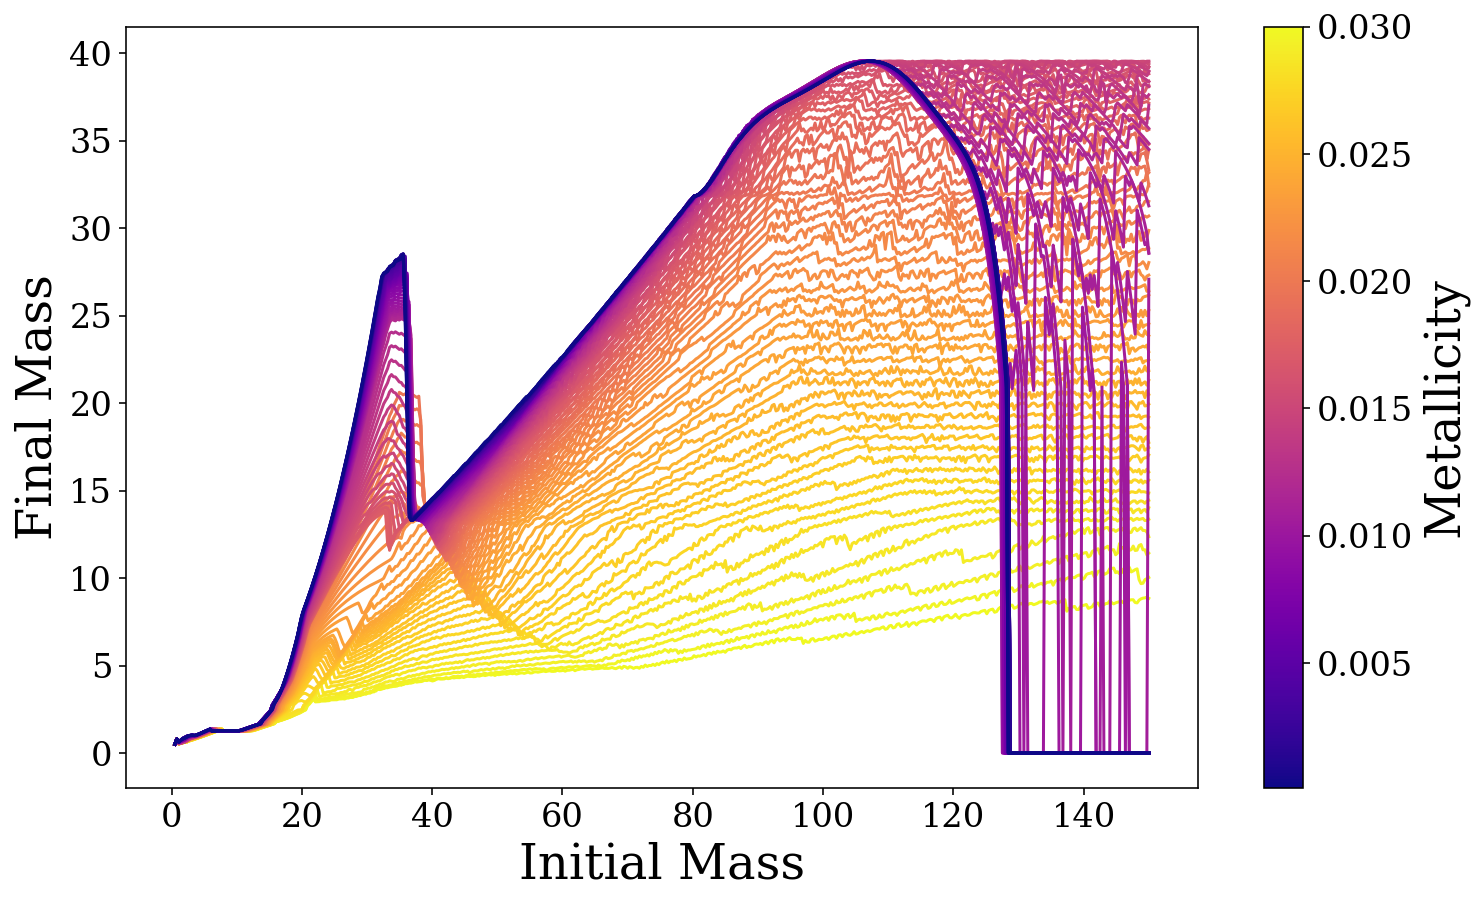

In [20]:
fig, ax = plt.subplots(1, figsize=(12, 7))

colours = plt.get_cmap("plasma", len(initial_Z))

for i in range(len(initial_Z)):
    mask = Z_sys == initial_Z[i]
    ax.plot(m_ZAMS[mask], m_end[mask], label=np.round(initial_Z[i], 4), color=colours(i), zorder=len(initial_Z) - i)
    
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=1e-4, vmax=3e-2), cmap="plasma"))
cbar.ax.set_ylabel("Metallicity", fontsize=fs)
cbar.ax.tick_params(labelsize=0.7*fs)

ax.set_xlabel("Initial Mass", fontsize=fs)
ax.set_ylabel("Final Mass", fontsize=fs)

ax.tick_params(labelsize=0.7*fs)
    
plt.show()

## old version

In [222]:
# define a range of masses from above brown dwarf to maximum COMPAS mass
mass_range = np.linspace(0.08, 200, 100)
dm = mass_range[1] - mass_range[0]
IMF_range = IMF(mass_range)

# define a range of lookback times up to the age of the Milky Way
lookback_time_range = np.linspace(0, 12, 1000) * u.Gyr
dt = (lookback_time_range[1] - lookback_time_range[0]).value
p_t_range = total_SFH(lookback_time_range)

# convert the times to average metallicities
avg_Z_range = average_metallicity(lookback_time_range)

M, TAU = np.meshgrid(mass_range, lookback_time_range)
Z = average_metallicity(TAU)

In [223]:
# calculate the masses assuming that star has died
dead_mass_range = final_mass(mass_range, avg_Z_range)

# only set the final mass to the dead mass if the star is no longer on its main sequence
final_mass_range = np.where(still_MS(M, Z, TAU), M, dead_mass_range)

In [224]:
# do the inner mass integral with IMF * m_final
inner_integral = np.trapz(final_mass_range * np.tile(IMF_range, (len(lookback_time_range), 1)), mass_range)
inner_integral = final_mass_range * np.tile(IMF_range, (len(lookback_time_range), 1)) * dm

# do the full integral over times
full_integral = p_t_range * inner_integral.sum(axis=1) * dt

avg_mass_today = full_integral.sum()